# PyTorch Workflow

Exploring an end-to-end PyTorch workflow.

I utilise the following resources:

1. https://github.com/mrdbourke/pytorch-deep-learning/blob/main/01_pytorch_workflow.ipynb
2. https://www.learnpytorch.io/01_pytorch_workflow/

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01_a_pytorch_workflow.png" width=900 alt="a pytorch workflow flowchat"/>

In [ ]:
import torch
from torch import nn # PyTorch's building blocks https://pytorch.org/docs/stable/nn.html
import matplotlib.pyplot as plt
import numpy as np

# PyTorch Version
torch.__version__

'2.6.0+cu124'

## 1. Data (preparing and loading).

Two main ideas are:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

<img src=https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-machine-learning-a-game-of-two-parts.png
width=900 alt="a game of 2 parts"/>

To showcase these steps we can generate some dummy data using the linear regression formula.

Using linear regressuion we'll make a stright line with known **parameters**.


In [ ]:
# Creating known parameters

bias = 0.3
weight = 0.7

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1) #the unsqueeze is important later for model building

y = weight*X + bias

#X, y

### Splitting data into training and testing set
creating a training and test set with our data.

In [ ]:
# Create a test/train split
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [ ]:
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

### Visualising

In [ ]:
def plot_predictions(train_data = X_train, train_label = y_train,
                     test_data = X_test, test_label = y_test,
                     predictions = None):
  """ Plots the train/test data and compares predictions. Outputs 1 Graph. """

  #Plot training data
  plt.scatter(train_data, train_label, c= "b", s = 4, label = "Training Data")

  #Plot testing data
  plt.scatter(X_test, y_test, c="g", s=4, label = "Testing Data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c = "r", s=4, label = "Predictions")

  #Show Legend
  plt.legend(prop={"size": 14})

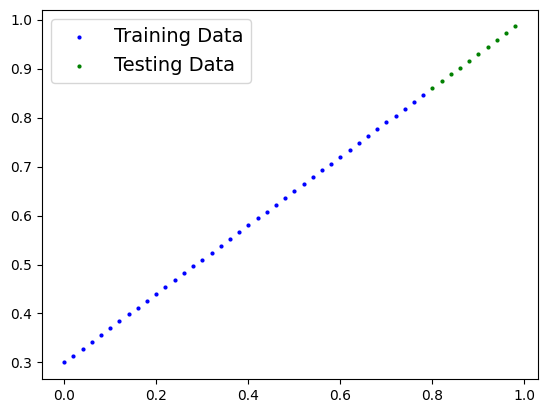

In [ ]:
plot_predictions()

## 2. Build Model
First PyTorch Model

<img src=https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-linear-model-annotated.png
width=900 alt="model building blocks"/>

In [ ]:
class LinearRegressionModel(nn.Module): #inherits from nn.Module - this is a subclass of nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.rand(1,
                              requires_grad = True,
                              dtype = torch.float))

    self.bias = nn.Parameter(torch.rand(1,
                           requires_grad= True,
                           dtype = torch.float))
    # Forward method
  def forward(self, x: torch.Tensor) -> torch.tensor: # <- "x" is the input data
    return self.weights*x + self.bias #this is the linear regression formula




###Checking the contents of the PyTorch model

We can check our model parameters using `.parameters()`

In [ ]:
# Creating random seed
#torch.manual_seed(42)

# Creating an instance of the model (this is a subcalss of nn.Module)
model_0 = LinearRegressionModel()

# Checking the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.5496], requires_grad=True),
 Parameter containing:
 tensor([0.6767], requires_grad=True)]

In [ ]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.5496])), ('bias', tensor([0.6767]))])

### Making predictions using `torch.inference_mode()`
When we pass data through the model, it will run it through the `forward()` method.

The ` with torch.inference_mode()` does not store the gradients (necessary for training but not for inferencing), this makes it faster than just using `y_pred = model_0(X_test)`

Inference is another term for prediction.

In [ ]:
# Model predictions
with torch.inference_mode():
  y_preds = model_0(X_test)
#y_preds, y_test

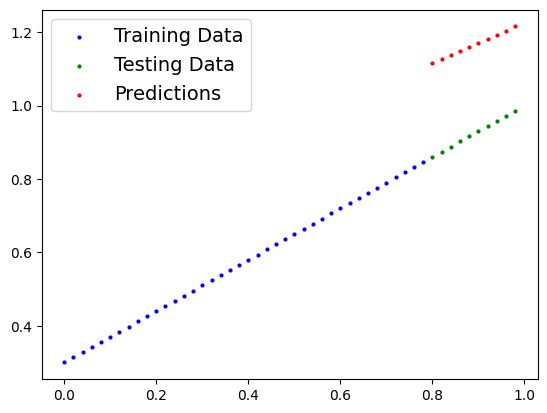

In [ ]:
# Visualising our predictions
plot_predictions(predictions= y_preds)

#Our prediction won't be very good for now

## 3. Train model

Things we need to train:

* **Cost functions:** We use criterion/loss/cost functions to measure how wrong the model predictions are to their true values. Lower is better.

* **Optimiser:** Tie together the loss function and model parameters (weights & bias) by updating the model in response to the output of the loss function. aka it tweeks the weights and bias to minimise the loss function.

Specifically in PyTorch, we will need:

* A training loop
* A testing loop

In [ ]:
# Checking our model's parameters (a value the model sets itself)
model_0.state_dict()

OrderedDict([('weights', tensor([0.5496])), ('bias', tensor([0.6767]))])

In [ ]:
# Loss function (MAE)
loss_fn = nn.L1Loss()

# Optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(params= model_0.parameters(),
                            lr = 0.01) # lr is learning rate
                                       # lr is a hyperparamter, a value that we choose ourselves

## Building a training loop and testing loop in PyTorch.

0. Loop throught the data and do steps below:
1. Forward pass (data passes through the `forward()` functions to make prediction)
2. Calculate loss (compare predictions to true values)
3. OPtimizer zero grad
4. Backpropagation
5. Optimizer step - use optim to improve loss (gradient descent)

In [ ]:
# Empty lists to keep track of important values
epoch_count = []
train_loss_values = []
test_loss_values = []

# An epcoh is one loop through the data.
epochs = 300

### TRAINING
# 0. Loop through the data.
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # sets all parameters that require gradients to require gradients

  # 1. Forward pass
  y_preds = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_preds, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad() # Resets the gradients each loop

  # 4. Backpropagation on the loss with respect to the params
  loss.backward()

  # 5. Optimizer step
  optimizer.step() # optimizer changes accumulate through the loop, thus we zero them in step 3

  ### TESTING
  model_0.eval()
  with torch.inference_mode():
    test_preds = model_0(X_test)
    test_loss = loss_fn(test_preds, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    train_loss_values.append(loss.detach().numpy())
    test_loss_values.append(test_loss.detach().numpy())
    print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")



Epoch: 0 | Train loss: 0.31805524230003357 | Test loss: 0.22938942909240723
Epoch: 10 | Train loss: 0.20284537971019745 | Test loss: 0.0946795865893364
Epoch: 20 | Train loss: 0.08770734071731567 | Test loss: 0.03918316215276718
Epoch: 30 | Train loss: 0.05137895420193672 | Test loss: 0.09448917210102081
Epoch: 40 | Train loss: 0.04600024223327637 | Test loss: 0.10224688053131104
Epoch: 50 | Train loss: 0.042456936091184616 | Test loss: 0.0980956181883812
Epoch: 60 | Train loss: 0.039011888206005096 | Test loss: 0.09050996601581573
Epoch: 70 | Train loss: 0.03557385131716728 | Test loss: 0.08223742246627808
Epoch: 80 | Train loss: 0.032138392329216 | Test loss: 0.07465176284313202
Epoch: 90 | Train loss: 0.028709042817354202 | Test loss: 0.06637920439243317
Epoch: 100 | Train loss: 0.025270232930779457 | Test loss: 0.0581066831946373
Epoch: 110 | Train loss: 0.02183646149933338 | Test loss: 0.05052100867033005
Epoch: 120 | Train loss: 0.01840541698038578 | Test loss: 0.0422484762966632

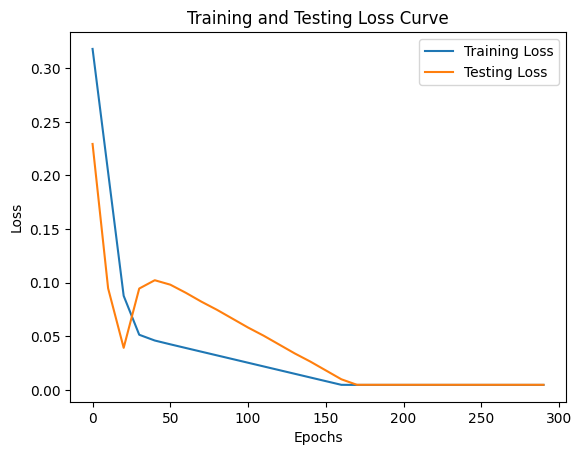

In [ ]:
#Visualising training and testing Loss Curves

plt.plot(epoch_count, train_loss_values, label = "Training Loss")
plt.plot(epoch_count, test_loss_values, label = "Testing Loss")
plt.title("Training and Testing Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(prop={"size": 10})

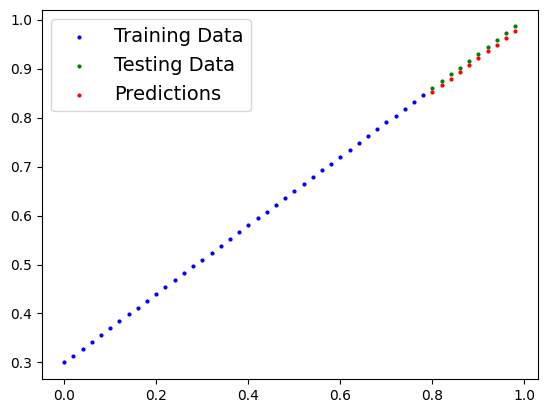

In [ ]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

plot_predictions(predictions = y_preds_new)

### Saving a model in PyTorch
https://pytorch.org/tutorials/beginner/saving_loading_models.html




## Three main ways to save and load models.
1. `torch.save` Saves a serialized object to disk using Python's pickle utility. Models, tensors and various other Python objects like dictionaries can be saved using torch.save.

2. `torch.load` 	Uses pickle's unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc).

3. `torch.nn.Module.load_state_dict` Loads a model's parameter dictionary (model.state_dict()) using a saved state_dict() object.

In [ ]:
from os import mkdir
from pathlib import Path

# 1. create "models" directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_0.state_dict(), #saving state_dcit only saves the models learned parameters
           f = MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [ ]:
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 root root 1680 May  8 16:25 models/01_pytorch_workflow_model_0.pth


## Loading a PyTorch model

Since we saved our model's `state_dict()` rather than the entire mode, we'll create a new instance of our model class and load the saved `state_dict()` into that.

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6916])), ('bias', tensor([0.2987]))])

In [ ]:
# to load the state_dict() we create new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict() to new model instance
loaded_model_0.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
# Making preds with laoded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)


In [ ]:
y_preds_new == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## Recap of what I've learnt

###Crete device-agnostic code.

If we've got a GPU, our code will run there.

If no GPU is available, the code will run in CPU.

In [ ]:
# setup device-agnostic code.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")


Using device: cuda


### Making a dummy dataset

In [ ]:
weight = 0.5
bias = 0.9

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [ ]:
# Train Test split

train_split = int(len(X) * 0.8)

X_train, y_train = X[:train_split], y[:train_split]

X_test, y_test = X[train_split:], y[train_split:]

In [ ]:
def plot_predictions(train_data = X_train, train_label = y_train,
                     test_data = X_test, test_label = y_test,
                     predictions = None):
  """ Plots the train/test data and compares predictions. Outputs 1 Graph. """

  #Plot training data
  plt.scatter(train_data, train_label, c= "b", s = 4, label = "Training Data")

  #Plot testing data
  plt.scatter(X_test, y_test, c="g", s=4, label = "Testing Data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c = "r", s=4, label = "Predictions")

  #Show Legend
  plt.legend(prop={"size": 14})

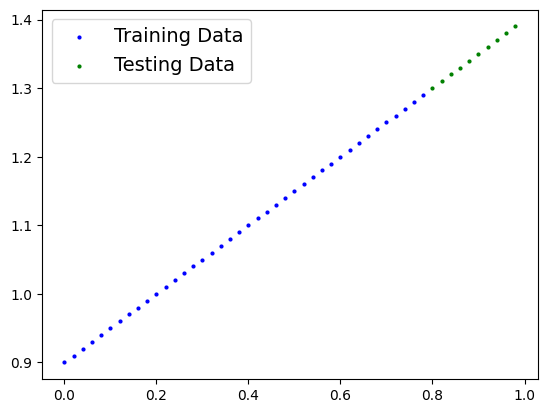

In [ ]:
plot_predictions()

### Building model
Using `nn.Linear()`

In [ ]:
class LinearRegression(nn.Module):
  def __init__(self):
    super().__init__()

    #inintilise linear layer which initializes model parameters
    self.linear_layer = nn.Linear(in_features = 1,
                             out_features = 1)

    # forward propagation method
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x) #perform the linear regression formula


In [ ]:
model = LinearRegression()
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[-0.5261]])),
             ('linear_layer.bias', tensor([-0.4967]))])

In [ ]:
# check model current device
next(model.parameters()).device

device(type='cpu')

In [ ]:
# Set the model to use target device

model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

In [ ]:
# Put the data on the GPU
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [ ]:
X_train.device

device(type='cuda', index=0)

### Training

* Los Function
* Optimizer
* Training Loop
* Testing Loop

In [ ]:
loss_function = nn.L1Loss()
model_optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.01)

epoch_tracker = []
train_loss_tracker = []
test_loss_tracker = []

epochs = 300

for epoch in range(epochs):
  model.train()

  #forward pass
  preds = model(X_train)


  # calculate the loss
  training_loss = loss_function(preds, y_train)

  # clear the optim gradient
  model_optimizer.zero_grad()

  # back propagation
  training_loss.backward()

  # optimizer step
  model_optimizer.step()

  # model evalution
  model.eval()

  with torch.inference_mode():
    model_test_preds = model(X_test)

    model_test_loss = loss_function(model_test_preds, y_test)

    epoch_tracker.append(epoch)
    train_loss_tracker.append(training_loss)
    test_loss_tracker.append(model_test_loss)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch} Training Loss: {training_loss} | Test Loss: {model_test_loss}")




Epoch: 0 Training Loss: 1.7969239950180054 | Test Loss: 2.2965152263641357
Epoch: 10 Training Loss: 1.6817140579223633 | Test Loss: 2.1618056297302246
Epoch: 20 Training Loss: 1.5665043592453003 | Test Loss: 2.0270957946777344
Epoch: 30 Training Loss: 1.4512943029403687 | Test Loss: 1.8923858404159546
Epoch: 40 Training Loss: 1.3360843658447266 | Test Loss: 1.7576760053634644
Epoch: 50 Training Loss: 1.220874309539795 | Test Loss: 1.6229660511016846
Epoch: 60 Training Loss: 1.1056644916534424 | Test Loss: 1.4882559776306152
Epoch: 70 Training Loss: 0.9904544949531555 | Test Loss: 1.3535460233688354
Epoch: 80 Training Loss: 0.8752444386482239 | Test Loss: 1.2188360691070557
Epoch: 90 Training Loss: 0.7600345015525818 | Test Loss: 1.0841259956359863
Epoch: 100 Training Loss: 0.6448245644569397 | Test Loss: 0.9494159817695618
Epoch: 110 Training Loss: 0.5296146273612976 | Test Loss: 0.8147061467170715
Epoch: 120 Training Loss: 0.4144047200679779 | Test Loss: 0.6799961924552917
Epoch: 130 

In [ ]:
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.3469]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.9643], device='cuda:0'))])

In [ ]:
weight, bias

(0.5, 0.9)

In [ ]:
# plt.plot(epoch,train_loss_tracker, label = "Training Loss")
# plt.plot(epoch,test_loss_tracker, label = "Testing Loss")
# plt.legend()
# plt.show()

In [ ]:
model.eval()

with torch.inference_mode():
  y_preds = model(X_test)
y_preds

tensor([[1.2418],
        [1.2487],
        [1.2557],
        [1.2626],
        [1.2695],
        [1.2765],
        [1.2834],
        [1.2904],
        [1.2973],
        [1.3042]], device='cuda:0')

In [ ]:
# need to send the data back to the cpu to be able to plot the data

X_train = X_train.cpu()
y_train = y_train.cpu()
X_test = X_test.cpu()
y_test = y_test.cpu()

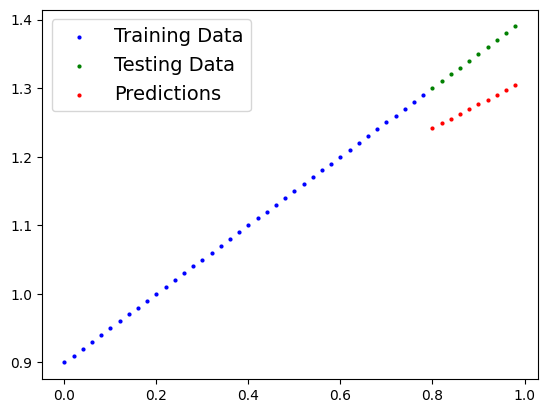

In [ ]:
plot_predictions(predictions=y_preds.cpu())

## Saving Model

In [ ]:
from os import mkdir
from pathlib import Path

# create model path
BETTER_MODELS_PATH = Path("Better_Models")

# make the directory
BETTER_MODELS_PATH.mkdir(parents = True, exist_ok = True)

# Create model save path
new_model_name = "better_linear_model.pth"

NEW_MODEL_SAVE_PATH = BETTER_MODELS_PATH / new_model_name

# Saving the model state_dict()
print(f"Saving new model to: {NEW_MODEL_SAVE_PATH}")
torch.save(obj = model.state_dict(), f = NEW_MODEL_SAVE_PATH)

Saving new model to: Better_Models/better_linear_model.pth


In [ ]:
# Load a PyTorch Model

In [ ]:
# Create new isntance of model
loaded_model = LinearRegression()

# Load saved model state_dict()

loaded_model.load_state_dict(torch.load(NEW_MODEL_SAVE_PATH))

# Put the loaded model to device
loaded_model.to(device)

LinearRegression(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
next(loaded_model.parameters()).device

device(type='cuda', index=0)

In [ ]:
loaded_model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.3469]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.9643], device='cuda:0'))])

In [ ]:
# Evaluate loaded model
loaded_model.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model(X_test.to(device))
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')